# Deep Music Genre Classification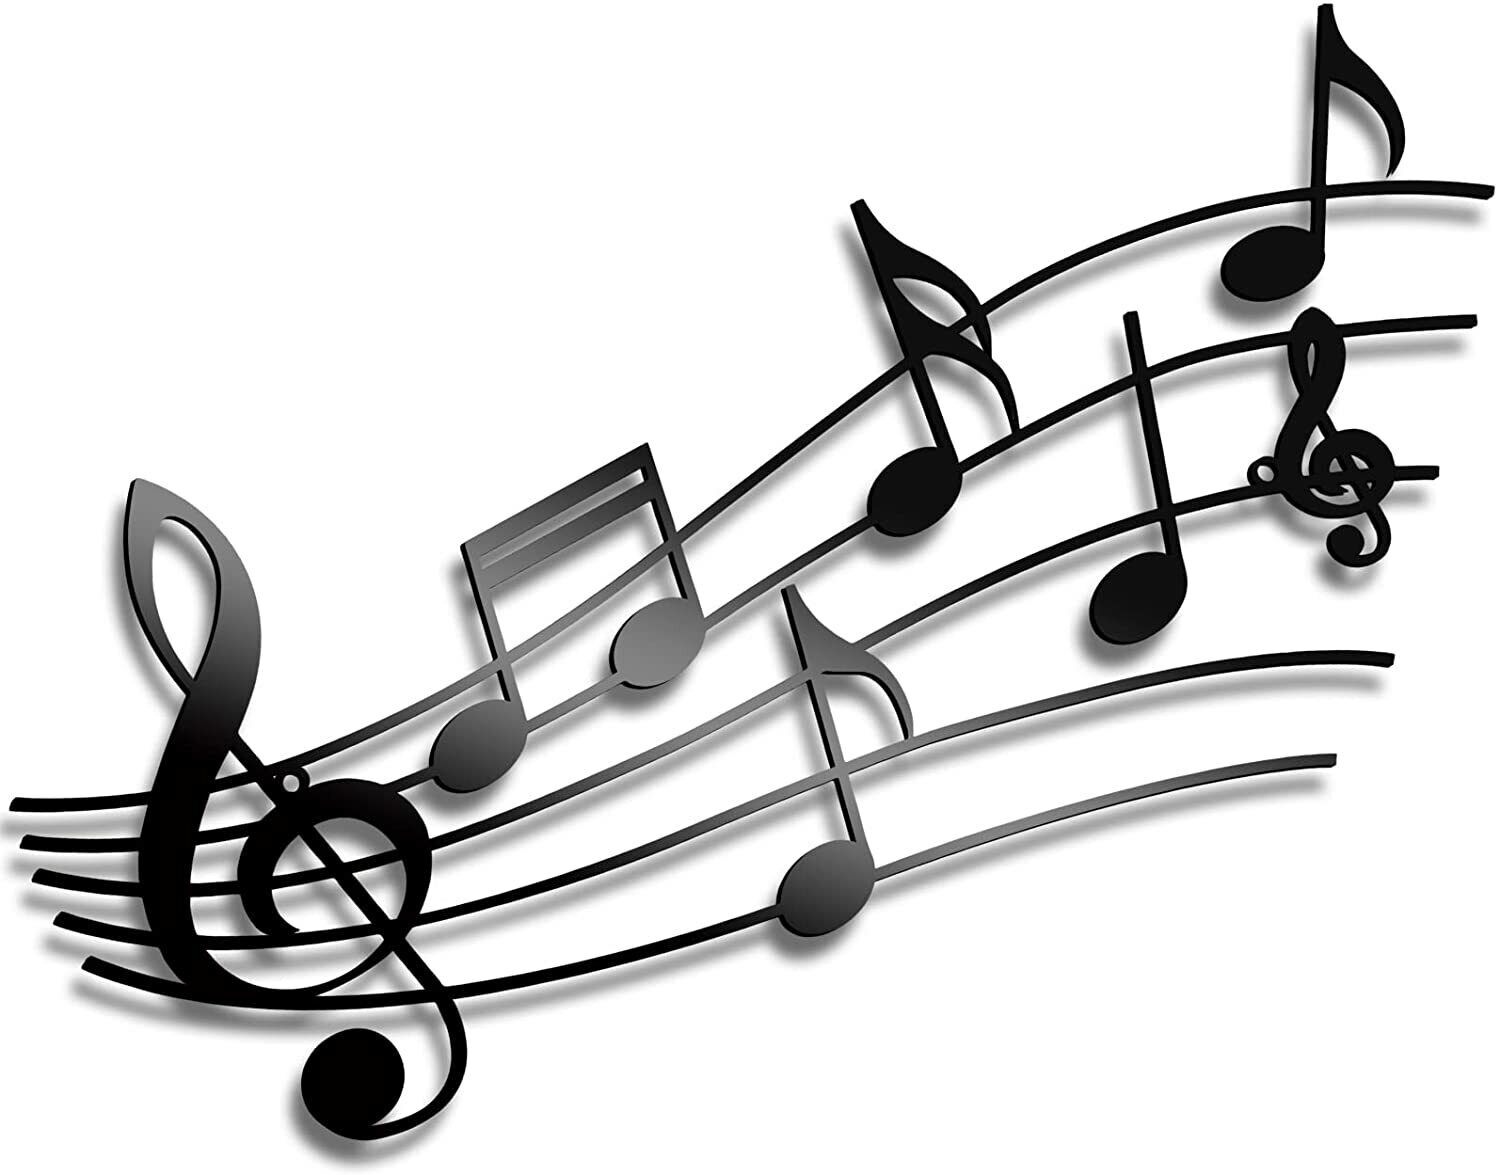

## Contribution Statement

In this blog post I collaborated with Liz Rightmire.

##Introduction

For this blog post I had this goal: classify songs into different genres

To accomplish this task I created three neural networks with Torch and trained them. The first neural network classifies the songs by lyrics only, the second neural netowork classifies the songs by engineering features, and the final uses both engineering features and lyrics to classify songs into genres. I then reflect on these results. After training these models I analyzed the word embeddings learned through this model, specifically focused on gendered words and word embeddings.

The base classification rate is 24.8%. After training, all the models grew in accuracy with the first model having a 35%, the second has about 32%, and the third has 30% accuracy rate on the test data. I also found through analyzing the word embeddings that word embeddings can encode bias from the data the model is trained on. Therefore I learned not only more about how to train neural networks but also how to analyze their impacts and fairness.

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/tcc_ceds_music.csv"
df = pd.read_csv(url)

Identifed important engineering features for the second and third neural networks.


In [ ]:
engineered_features = ['dating', 'violence', 'world/life', 'night/time','shake the audience','family/gospel', 'romantic', 'communication','obscene', 'music', 'movement/places', 'light/visual perceptions','family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability','loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']

Encode the genres which are our goals for classification.

In [ ]:
genres = {
    "pop"   : 0,
    "country" : 1,
    "blues" : 2,
    "jazz" : 3,
    "reggae" : 4,
    "rock" : 5,
    "hip hop" : 6
 }

In [ ]:
df = df[df["genre"].apply(lambda x: x in genres.keys())]
df["genre"] = df["genre"].apply(genres.get)

Use this to calculate the base rate pre training:

In [ ]:
df.groupby("genre").size() / len(df)

genre
0    0.248202
1    0.191915
2    0.162273
3    0.135521
4    0.088045
5    0.142182
6    0.031862
dtype: float64

Therfore our base rate that we want to improve upon with training is 0.248202 as if we only guessed genre 0 (or pop) we would get a 24.8% accuracy rate.

## 1. Neural Network
My first network uses only the lyrics to perform the classification task.

Data loader class for my networks. Return batches of data containing both the text features and the engineered features

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataFromDF(Dataset):
    def __init__(self, df):
        self.df = df

    def __getitem__(self, index):
        return self.df.iloc[index, 5],  self.df.iloc[index, 4], self.df.iloc[index, 6:28]

    def __len__(self):
        return len(self.df)

Make training and validation datasets through test train split

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df,shuffle = True, test_size = 0.2)
train_data = TextDataFromDF(df_train)
val_data   = TextDataFromDF(df_val)

Tokenize the lyrics

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch

tokenizer = get_tokenizer('basic_english')

Get a vocabulary from our data

In [ ]:
def yield_tokens(data_iter):
    for text, features, _ in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"], min_freq = 50)
vocab.set_default_index(vocab["<unk>"])

Text pipeline tokenizes text

In [ ]:
from sklearn.preprocessing import LabelEncoder

max_len = 30
num_tokens = len(vocab.get_itos())
def text_pipeline(x):
    tokens = vocab(tokenizer(x))
    y = torch.zeros(max_len, dtype=torch.int64) + num_tokens
    if len(tokens) > max_len:
        tokens = tokens[0:max_len]
    y[0:len(tokens)] = torch.tensor(tokens,dtype=torch.int64)
    return y

label_pipeline = lambda x: int(x)

Code to send batches of data to our training loop

In [ ]:
def collate_batch(batch):
    label_list, text_list, feature_list = [], [], []

    for (_text, _label, _features) in batch:

        # make feature pipeline that converts to torch tensor
        feature_list.append(torch.tensor(_features))

        # add label to list
        label_list.append(label_pipeline(_label))

         # add text (as sequence of integers) to list
        processed_text = text_pipeline(_text)
        text_list.append(processed_text)

    feature_list = torch.stack(feature_list)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.stack(text_list)
    return text_list, label_list, feature_list

Call DataLoader on train and validation data

In [ ]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True, collate_fn=collate_batch)

Initialize the model using only text feaures.

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, max_len, num_class, hidden_dim=128):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.dropout = nn.Dropout (p=0.2)
        self.fc = nn.Linear(embedding_dim, num_class)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.mean(axis=1)
        x = self.fc(x)
        return(x)

Using the optimizer and loss that Phil used in class.

In [ ]:
vocab_size = len(vocab)
embedding_dim = 3
max_len =100
num_classes = 7
lyrics_model = TextClassificationModel(vocab_size, embedding_dim, max_len, num_classes)

optimizer = torch.optim.Adam(lyrics_model.parameters(), lr=.001)
loss_fn = torch.nn.CrossEntropyLoss()


Train model with training loop with options to use lyrics, engineering features, or both lyrics and engineering features. Pass in the model and dataloader:

In [ ]:
import time


def train(model, dataloader, use_lyrics=True, use_engineering=True):
    epoch_start_time = time.time()
    # keep track of some counts for measuring accuracy
    total_acc, total_count = 0, 0
    log_interval = 300
    start_time = time.time()

    for idx, (text, label, features) in enumerate(dataloader):

        # zero gradients
        optimizer.zero_grad()
        # form prediction on batch
        predicted_label = ''

        # send model specific features based on specifications
        if(use_engineering and not use_lyrics):
            predicted_label = model(features)
        elif(use_lyrics and not use_engineering):
            predicted_label = model(text)
        elif(use_lyrics and use_engineering):
            predicted_label = model(text, features)

        # evaluate loss on prediction
        loss = loss_fn(predicted_label, label)
        # compute gradient
        loss.backward()
        # take an optimization step
        optimizer.step()

        # for printing accuracy
        total_acc   += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)

    print(f'| epoch {epoch:3d} | train accuracy {total_acc/total_count:8.3f} | time: {time.time() - epoch_start_time:5.2f}s')

def evaluate(model, dataloader, use_lyrics=True, use_engineering=True):

    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label, features) in enumerate(dataloader):

            # form prediction on batch using specified features
            if(use_engineering and not use_lyrics):
                predicted_label = model(features)
            elif(use_lyrics and not use_engineering):
                predicted_label = model(text)
            elif(use_lyrics and use_engineering):
                predicted_label = model(text, features)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

Call the training loop for 40 EPOCHs

In [ ]:
EPOCHS = 40
for epoch in range(1, EPOCHS + 1):
    train(lyrics_model, train_loader, use_lyrics=True, use_engineering=False)

| epoch   1 | train accuracy    0.240 | time: 18.62s
| epoch   2 | train accuracy    0.263 | time: 18.36s
| epoch   3 | train accuracy    0.269 | time: 20.02s
| epoch   4 | train accuracy    0.279 | time: 21.54s
| epoch   5 | train accuracy    0.289 | time: 22.04s
| epoch   6 | train accuracy    0.298 | time: 19.96s
| epoch   7 | train accuracy    0.308 | time: 18.47s
| epoch   8 | train accuracy    0.317 | time: 18.71s
| epoch   9 | train accuracy    0.326 | time: 18.54s
| epoch  10 | train accuracy    0.334 | time: 19.31s
| epoch  11 | train accuracy    0.341 | time: 18.80s
| epoch  12 | train accuracy    0.348 | time: 18.43s
| epoch  13 | train accuracy    0.355 | time: 19.19s
| epoch  14 | train accuracy    0.360 | time: 18.87s
| epoch  15 | train accuracy    0.363 | time: 19.57s
| epoch  16 | train accuracy    0.368 | time: 18.08s
| epoch  17 | train accuracy    0.373 | time: 19.12s
| epoch  18 | train accuracy    0.376 | time: 17.63s
| epoch  19 | train accuracy    0.379 | time: 

Now evaluate the accuracy of the model with the validation data only using the lyrics.

In [ ]:
evaluate(lyrics_model, val_loader, use_lyrics=True, use_engineering=False)

0.3515418502202643

We end up with a 35.2% accuracy after training, which is much higher than our base rate of 24.8%.

## 2. Neural Network

This neural network uses engineering features only to perform the classifications.

Perform train test split

In [ ]:
df_train, df_val = train_test_split(df,shuffle = True, test_size = 0.2)
train_data = TextDataFromDF(df_train)
val_data   = TextDataFromDF(df_val)

Initialize a model that specifically uses engineering features

In [ ]:
from torch import nn

class EngineeringClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, num_classes),
            nn.Softmax(dim=1) )

    def forward(self, x):
        x = x.float()
        x = torch.flatten(x, 1)
        x = self.model(x)
        return x


Use dataloader to get same dataloader for test and validation data

In [ ]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True, collate_fn=collate_batch)

In [ ]:
input_size = 22
num_classes = 7
engineer_model = EngineeringClassificationModel(input_size, num_classes)

optimizer = torch.optim.Adam(engineer_model.parameters(), lr=.0001)
loss_fn = torch.nn.CrossEntropyLoss()

Do the training loop for 40 EPOCHS

In [ ]:
EPOCHS = 40
for epoch in range(1, EPOCHS + 1):
    train(engineer_model, train_loader, use_lyrics=False, use_engineering=True)

| epoch   1 | train accuracy    0.246 | time: 21.43s
| epoch   2 | train accuracy    0.247 | time: 22.65s
| epoch   3 | train accuracy    0.246 | time: 21.08s
| epoch   4 | train accuracy    0.246 | time: 20.59s
| epoch   5 | train accuracy    0.249 | time: 21.08s
| epoch   6 | train accuracy    0.249 | time: 20.27s
| epoch   7 | train accuracy    0.251 | time: 21.55s
| epoch   8 | train accuracy    0.257 | time: 20.91s
| epoch   9 | train accuracy    0.259 | time: 22.50s
| epoch  10 | train accuracy    0.263 | time: 21.53s
| epoch  11 | train accuracy    0.266 | time: 20.14s
| epoch  12 | train accuracy    0.273 | time: 21.01s
| epoch  13 | train accuracy    0.280 | time: 21.52s
| epoch  14 | train accuracy    0.281 | time: 19.91s
| epoch  15 | train accuracy    0.287 | time: 21.00s
| epoch  16 | train accuracy    0.289 | time: 19.88s
| epoch  17 | train accuracy    0.294 | time: 22.62s
| epoch  18 | train accuracy    0.299 | time: 21.41s
| epoch  19 | train accuracy    0.301 | time: 

In [ ]:
evaluate(engineer_model, val_loader, use_lyrics=False, use_engineering=True)

0.32863436123348017

This accuracy is above the base rate of 24.8%, so we know that this neural network is learning! However, this is slightly lower than the first neural network perhaps indicating that lyrics are more helpful in classifying genres than engineering features.

## 3. Neural Network

This third network uses both the lyrics and the engineered features to perform the classification task.

In [ ]:
df_train, df_val = train_test_split(df,shuffle = True, test_size = 0.2)
train_data = TextDataFromDF(df_train)
val_data   = TextDataFromDF(df_val)

Initialize model that uses lyrics and engineering features

In [ ]:
class CombinedNet(nn.Module):

    def __init__(self, vocab_size, embedding_dim, num_features, num_classes):
        super().__init__()

        # Text Pipeline
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.dropout = nn.Dropout (p=0.2)
        self.text_fc = nn.Linear(embedding_dim, 128)

        # Engineered Features Pipeline
        self.engineered_model = nn.Sequential(nn.Linear(num_features, 256),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(256, 128))
        # Combined Layers
        self.combine_fc = nn.Linear(12928, 64)
        self.output_fc = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, text_features, engineer_features):

        # text pipeline
        text_embedded = self.embedding(text_features)
        text_processed = self.dropout(text_embedded)
        text_processed = self.text_fc(text_processed)

        # engineered features
        engineer_features = engineer_features.float()
        engineered_processed = self.engineered_model(engineer_features)

        # flatten text
        text_processed = torch.flatten(text_processed, 1)

        # combine processed text and engineering features
        combined = torch.cat((text_processed, engineered_processed), dim=1)

        # pass x through a couple more fully-connected layers and return output
        combined = self.combine_fc(combined)
        output = self.output_fc(combined)
        output = self.softmax(output)

        return output

Call the DataLoader with the same parameters as before.

In [ ]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True, collate_fn=collate_batch)

Initialize the model with speific parameters

In [ ]:
vocab_size = len(vocab)
embedding_dim = 3
num_features = 22
num_classes = 7

combined_model = CombinedNet(vocab_size, embedding_dim, num_features, num_classes)

optimizer = torch.optim.Adam(combined_model.parameters(), lr=.00005)
loss_fn = torch.nn.CrossEntropyLoss()

Complete the training loop for 40 EPOCHS both engineering features and lyrics

In [ ]:
EPOCHS = 40
for epoch in range(1, EPOCHS + 1):
    train(combined_model, train_loader, use_lyrics=True, use_engineering=True)

| epoch   1 | train accuracy    0.243 | time: 43.72s
| epoch   2 | train accuracy    0.253 | time: 49.11s
| epoch   3 | train accuracy    0.255 | time: 42.87s
| epoch   4 | train accuracy    0.258 | time: 43.07s
| epoch   5 | train accuracy    0.260 | time: 44.59s
| epoch   6 | train accuracy    0.263 | time: 42.92s
| epoch   7 | train accuracy    0.266 | time: 42.98s
| epoch   8 | train accuracy    0.266 | time: 44.00s
| epoch   9 | train accuracy    0.270 | time: 44.15s
| epoch  10 | train accuracy    0.271 | time: 43.29s
| epoch  11 | train accuracy    0.268 | time: 44.25s
| epoch  12 | train accuracy    0.278 | time: 43.16s
| epoch  13 | train accuracy    0.275 | time: 44.15s
| epoch  14 | train accuracy    0.283 | time: 46.28s
| epoch  15 | train accuracy    0.284 | time: 42.80s
| epoch  16 | train accuracy    0.288 | time: 44.57s
| epoch  17 | train accuracy    0.291 | time: 43.91s
| epoch  18 | train accuracy    0.302 | time: 43.19s
| epoch  19 | train accuracy    0.300 | time: 

In [ ]:
evaluate(combined_model, val_loader, use_lyrics=True, use_engineering=True)

0.3013215859030837

We end up with a 30% validation accuracy, which is higher than our 24.8% base rate.

## 4. Visualize word embeddings

Goal: visualize the embeddings learned by my model and analyze these visualizations.

Lets extract the embedding matrix with the model we trained using both the lyrics and the engineering features

In [ ]:
embedding_matrix = lyrics_model.embedding.cpu().weight.data.numpy()

In [ ]:
tokens = vocab.get_itos()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(embedding_matrix)

In [ ]:
tokens = vocab.get_itos()
tokens.append(" ")
embedding_df = pd.DataFrame({
    'word' : tokens,
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

embedding_df

,word,x0,x1
0,<unk>,-0.977003,-1.389344
1,know,0.714336,1.447385
2,like,-0.867101,-0.542019
3,time,-1.194328,-2.167107
4,come,-0.376801,-0.720566
...,...,...,...
2888,settin,0.907473,0.076848
2889,soda,0.843981,0.102353
2890,tighten,-1.307797,-1.214868
2891,woohoo,0.351801,1.301385


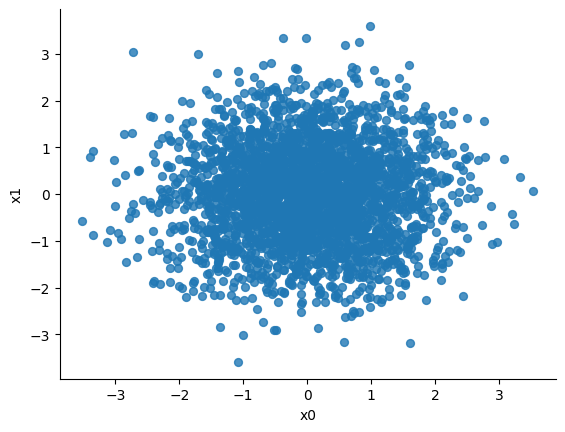

In [ ]:
# @title x0 vs x1

from matplotlib import pyplot as plt
embedding_df.plot(kind='scatter', x='x0', y='x1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Visualize the embeddings in a plot.

It is hard to see a pattern in this plot

Lets see gendered distinctions in the word embeddings. visualize with a slightly altered list of gendered words from [Man is to Computer Programmer as Woman is to Homemaker?
Debiasing Word Embeddings](https://arxiv.org/pdf/1607.06520) combined with additional gendered words found in the vocabulary.

In [ ]:
import numpy as np

feminine = ["she", "her", "woman"]
masculine = ["he", "him", "man"]


highlight_1 = ["heavy", "commit", "game", "tactical", "firepower", "reel", "hoped", "command", "caused", "scrimmage","shoot","grind", "grow","lead"
               "drafted", "builder", "hay", "yard", "brilliant", "hard", "mean", "kill", "fight", "genius", "cocky", "journeyman", "ties",
               "guru", "sharply", "rule", "brass", "governor", "burly", "slow", "strong", "fast","powerful", "muscles", "bleed", "push"]
highlight_2 = ["tote", "treats", "browsing", "baby", "crafts", "love", "sweet", "kiss", "light", "trimester", "tanning", "model",
                "beautiful", "cake", "victims", "sewing", "dress", "dance", "pageant", "divorce", "thighs", "bitch", "dancers", "crazy",
               "devil","heart", "hold", "lust", "sassy", "breasts", "body","mouth","skin" "cry", "lie", "darling", "dancer", "pearls", "vases", "actress"]
print(len(highlight_1))
print(len(highlight_2))

def gender_mapper(x):
    if x in feminine:
        return 1
    elif x in masculine:
        return 4
    elif x in highlight_1:
        return 3
    elif x in highlight_2:
        return 2
    else:
        return 0

embedding_df["highlight"] = embedding_df["word"].apply(gender_mapper)
embedding_df["size"]      = np.array(1.0 + 50*(embedding_df["highlight"] > 0))

sub_df = embedding_df[embedding_df["highlight"] > 0]


39
39


In [ ]:
import plotly.express as px

fig = px.scatter(sub_df,
                 x = "x0",
                 y = "x1",
                 color = "highlight",
                 size = list(sub_df["size"]),
                 size_max = 10,
                 hover_name = "word",
                 text = "word")

fig.update_traces(textposition='top center')

fig.show()

Here we can see visualized that man is closer to words like commit, grind, fight, and devil whereas woman is closer to model, victims, slow, and sweet. Therefore we can conclude that the learned word embeddings encode gender bias from the data they are trained on.

## Conclusion

All three neural networks are able to learn and create a classification rate that is higher than the base rate of 24.8%. The first neural network that uses only lyrics has a classification accuracy on the validation data of 35%. The second neural network that uses only engineering features has a classification accuracy on the validation data of 32%. And finally, the third neural network that uses both lyrics and engineering features has a classification accuracy on the validation data of 30%. It is possible that these differences come from the layers chosen in the models or the learning rates. But overall, we can conclude based on my results that it is more useful to use just the lyrics as opposed to using the engineering features to classify songs into genres.

Overall, I learned from this blog post how train neural networks, how to tokenize text and use that as part of a model, and how to evaluate word embeddings learned from training. From my results I found that word embeddings can sometimes contain gender bias that reflects the data that they are trained on. Therefore, it is important to investigate what decisions are being made based on these word embeddings. I was able to understand more about natural language processing as a field and understand how to build layers for neural networks and choose learning rates that increase accuracy. This blog post tied to together a lot of my understanding in the class: the implementation of neural networks, the application of machine learning, and the analyzation of fairness within these systems.